<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Implementing_univariate_Recurrent_Neural_Networks_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing univariate Recurrent Neural Networks (RNN)**

## **1. Introduction and data gathering**

In our first practical contact with Recurrent Neural Networks (RNNs) we will implement a model to predict stock **prices** (rather than returns, as we have seen in previous modules). This has an importance, because prices are closer to be interpreted as a sequences than returns. This makes them potentially more predictive using RNNs than returns.

As usual, we will start by downloading price data from Yahoo! finance. Note that we take prices from just one stock, our usual suspect Apple Inc., to explore the time-series univariate prediction case.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

We start by gathering the data and defining the output as next day's close price:

In [2]:
df = yf.download("AAPL", start="2010-01-01", end="2022-04-11")
del df["Volume"]
df["Output"] = df.Close.shift(-1)
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
print("Length of data frame: ", len(df))
df.head()

Length of data frame:  3089


,Date,Open,High,Low,Close,Adj Close,Output
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461976,7.656429
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473148,7.534643
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370185,7.520714
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,7.570714
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,7.503929


## **2. Validation, train and test sample definition**

Next, we proceed to define our training, test, and validation sets. Note that we will train using the 98% of the sample. The validation set will be 20% of the training test. We also need to define a 'window' of observations that we are going to take as a sequence input to our network. In this case we choose a window of 20, which means that the last 20 prices (observations) will be incorporated into the sequence of inputs for the network. Note that not all of these may end up playing a big role in the prediction (this is for the training to decide), but we will give the network the possibility to consider up to 20 past prices.

Also, note that these, and others, parameters can be included as hyperparameters of the models that we can tune to achieve maximum performance of the algorithm. This is something we leave for future implementations of the Neural Network.

In [4]:
# First, we deal with the definition of the training, test, and validations sets sizes
val_split = 0.2
train_split = 0.98
train_size = int(len(df) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df) - train_size)

window_size = 20  # How many daily prices do I want to incorporate in the input sequence for the network?

ts = test_size
split_time = len(df) - ts
test_time = df.iloc[split_time + window_size :, 0:1].values

# Second, we actually define the input matrix for train (X_train) and test (X_test), as well as the output vector (y_train and y_test). See how we select 'Adj close' column for the Xdf matrix.
# Note that these will need further work afterwards, in order to incorporate the info from the 'sequence' of observations
Xdf, ydf = df.iloc[:, 4:5], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

# Third, we proceed with scaling inputs to the model. Note how this is specially important now (compare to past tasks) because we are no longer dealing with returns, but with prices!
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)


# Lastly, because we want a time series with up to 20 (window_size) past observations, we need to append these observations into our matrix/vectors!
training_time = df.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Size of X vector in training:", X_train.shape)
print("Size of Y vector in training:", y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])


X_test, y_test = np.array(X_test), np.array(y_test)
print("Size of X vector in test:", X_test.shape)
print("Size of Y vector in test:", y_test.shape)
print("Number of features in the model: ", n_features)

Size of X vector in training: (3007, 20, 1)
Size of Y vector in training: (3007, 1)
Size of X vector in test: (42, 20, 1)
Size of Y vector in test: (62, 1)
Number of features in the model:  1


## **3. Defining the RNN model**

Once we have pre-processed the input and output data of our network, let's build it!

We will start with a very simple RNN that considers 5 hidden layers (4 simple RNN layers + 1 final dense layer). Each of the RNN layers will have 50 neurons. We apply a Dropout of 20% after each of the RNN layers. Finally, before the single-unit final output layer, we will apply a dense layer with 10 neurons. As you know already, this architecture is kind of random. We will play around with the composition of the network once we move to more advanced models through hyperparameter tuning.

A novel thing of RNNs is that we can set the 'return_sequences' argument to True or False, depending on whether we want to pass the last output (if False) or the whole sequence (if True) to the next layer. More info on this here:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(
            50, return_sequences=True, input_shape=(X_train.shape[1], n_features)
        ),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Dense(1),
    ]
)

So, how does the model architecture look like?

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

Note how here the number of parameters to be trained by the model is defined a little bit different at each step. For example, for the second RNN layer, note that we have a total of 5,050 parameters. Where does this number come from?

Well, 50x50 + 50x50 + 50x1 = 5,050 parameters. In other words, outputs from previous layer (50) times neurons in this layer (50) plus the neurons in the layer times themselves (50x50), plus the bias term vector (50x1).  

Where does the 2,600 parameters of the first layer come from? Well, 50x50 (neurons in the layer) + 50x1 (neurons times number of model features) + 50x1 (bias terms) = 2,600

Alike we did for other models, if we sum up all the parameters in the different layers we end up with 18,271 parameters to be trained in this basic model.

## **4. Model training**

Now, we can proceed with model training. As you will see, there is nothing really new about this and basically training works in exactly the same way once we have defined our hidden layers as 'recurrent' ones.

In [7]:
from keras.callbacks import EarlyStopping

hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    verbose=1,
    callbacks=[es],
)

Epoch 1/500
38/38 [==============================] - 7s 44ms/step - loss: 0.8405 - val_loss: 0.3168
Epoch 2/500
38/38 [==============================] - 1s 25ms/step - loss: 0.6627 - val_loss: 0.4194
Epoch 3/500
38/38 [==============================] - 1s 26ms/step - loss: 0.6006 - val_loss: 0.3762
Epoch 4/500
38/38 [==============================] - 1s 27ms/step - loss: 0.5714 - val_loss: 0.2411
Epoch 5/500
38/38 [==============================] - 1s 26ms/step - loss: 0.5453 - val_loss: 0.1652
Epoch 6/500
38/38 [==============================] - 1s 28ms/step - loss: 0.5088 - val_loss: 0.1410
Epoch 7/500
38/38 [==============================] - 1s 28ms/step - loss: 0.4705 - val_loss: 0.1188
Epoch 8/500
38/38 [==============================] - 1s 26ms/step - loss: 0.4609 - val_loss: 0.1410
Epoch 9/500
38/38 [==============================] - 1s 28ms/step - loss: 0.4393 - val_loss: 0.1215
Epoch 10/500
38/38 [==============================] - 2s 40ms/step - loss: 0.4088 - val_loss: 0.1516

Next, as usual, we will visualize our predictions in the test sample, undergoing the usual inverse transform to un-do the scaling process:

In [8]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()

2/2 [==============================] - 0s 12ms/step


In [9]:
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred RNN": prediction, "values": values}
)
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%Y-%m-%d")
df_predictions.head()

,Date,Pred RNN,values
0,2022-02-09,184.835953,172.119995
1,2022-02-10,185.660019,168.639999
2,2022-02-11,187.722244,168.880005
3,2022-02-14,187.384048,172.789993
4,2022-02-15,187.230988,172.550003


And, finally, in a plot:

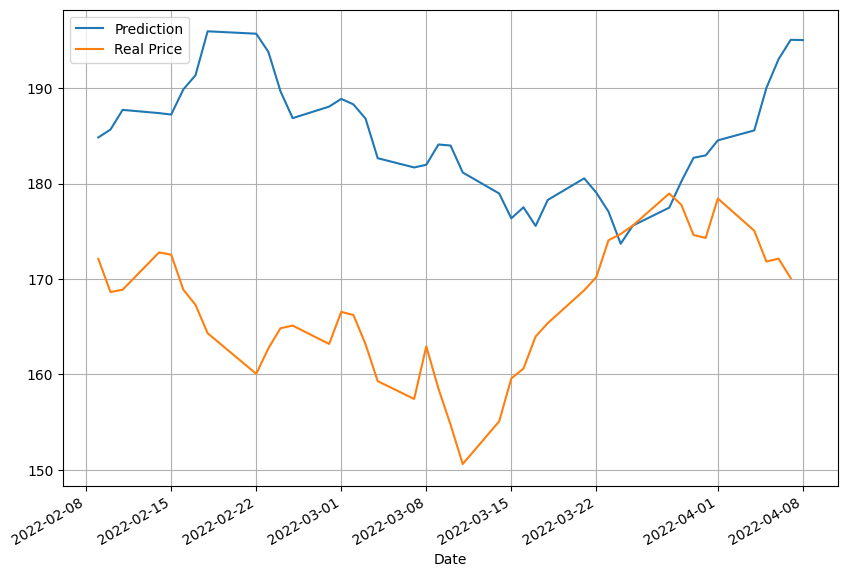

In [10]:
import matplotlib.pyplot as plt

plt_1 = plt.figure(figsize=(10, 7))
ax = plt.gca()
df_predictions.plot(x="Date", y="Pred RNN", label="Prediction", ax=ax)
df_predictions.plot(x="Date", y="values", label="Real Price", ax=ax)
plt.grid()
plt.show()

As you can see, our model does not perform so well for predicting the time-series of prices given a sequence. It kind of 'guesses' part of the trend, but is far from being a nice tool to closely predict future stock prices.

## **5. Conclusion**

In this lesson we have implemented our first Recurrent Neural Network (RNN) using a sequence of 20 past prices to predict future ones. We have seen that the predictive performance of this model is not so great after all. But there are lots of things to be done in terms of improving the model. This is what we will tackle in the next lessons, which will also serve as a good excuse to introduce the details of how forward and backprop work in RNN models.